### Figures 4-5

The density plots show the correlation between the chromatin accessibility measured by ATAC-seq and the acetylation and methylation profiles which are related to Acetyl-CoA and SAM fluxes.

In [41]:
import pandas as pd
import numpy as np
import cobra
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from scipy.interpolate import interp1d
from scipy.stats import mannwhitneyu 
from scipy.stats import gaussian_kde

/tmp/ipykernel_172013/675695165.py:12: UserWarning: DelftStack
  warnings.warn('DelftStack')


In [42]:
#upload files

folder="/home/bguzman/jupyter/UI/YMC/"
#RNA-seq from Kuang et al. (2014) 
fpkm=pd.read_csv(folder+"data/KuangRNAseq_15", sep="\t",index_col=0)
#ATAC-seq from Gowans et al. (2018)
atac=pd.read_csv(folder+"data/GSE101290_normalized_atac_counts.csv",index_col=0)
#stages YMC from Kuang et al. (2014)
OX= pd.read_csv(folder+"data/kuangOX.txt", sep="\t")
RB= pd.read_csv(folder+"data/kuangRB.txt", sep="\t")
RC= pd.read_csv(folder+"data/kuangRC.txt", sep="\t")
#Fluxes of ACOA and SAM from Pheflux2.0
ACOA_all=pd.read_csv(folder+"analysis/heatmaps_15_times/vectorAC_15_allflux.csv",index_col=0)
SAM_all=pd.read_csv(folder+"analysis/heatmaps_15_times/vectorME_15_allflux.csv",index_col=0)
#ChIP-seq from Kuang et al. (2014)
H3K9ac=pd.read_csv(folder+"analysis/dfi_T_15_ac.csv", index_col=0)
H3K4me3=pd.read_csv(folder+"analysis/dfi_T_15_me.csv", index_col=0)


In [43]:
#Separate the lists of each stage
df_fpkm=fpkm.iloc[0:-2,-16::] 

In [44]:
#Get average between the different elements of replicates 1, 2; 3. 4; 5, 6.
genes=atac.index
T1=list((atac.iloc[: , 1].values+atac.iloc[: , 2].values)/2)
T2=list((atac.iloc[: , 3].values+atac.iloc[: , 4].values)/2)
T3=list((atac.iloc[: , 5].values+atac.iloc[: , 6].values)/2)
T4=list((atac.iloc[: , 7].values+atac.iloc[: , 8].values)/2)
T5=list((atac.iloc[: , 9].values+atac.iloc[: , 10].values)/2)
T6=list((atac.iloc[: , 11].values+atac.iloc[: , 12].values)/2)

In [45]:
#Make df from the lists made with the averages of the replicates
import pandas as pd
import numpy as np
lst1 = genes
lst2 = T2 # RC
lst3= T3  # OX
lst4= T4  # OX
lst5= T5  # RB
lst6= T6  # RB
lst7= T1  # RC
atac_prom = pd.DataFrame(list(zip(lst1,lst2,lst3,lst4,lst5,lst6,lst7)), columns = ['Genes','T1','T2','T3','T4','T5','T6'])
#set the gene.id column as index to make the heatmap
df_atac = atac_prom.set_index(['Genes'])

In [46]:
#Define lists with genes by stage
lista_RC=list(RC.iloc[0:-2,0])
lista_OX=list(OX.iloc[0:-2,0])
lista_RB=list(RB.iloc[0:-2,0])

In [47]:
#Stage lists in atac-seq
list_1=lista_RC
list_2=atac.index
from collections import Counter
cnt1 = Counter(list_1)
cnt2 = Counter(list_2)
lista_RB_ss= [key for key, counts in cnt2.items() if cnt1[key] == counts]

list_3=lista_OX
list_4=atac.index
from collections import Counter
cnt3 = Counter(list_3)
cnt4 = Counter(list_4)
lista_OX_ss= [key for key, counts in cnt4.items() if cnt3[key] == counts]

list_5=lista_RB
list_6=atac.index
from collections import Counter
cnt5 = Counter(list_5)
cnt6 = Counter(list_6)
lista_RB_ss= [key for key, counts in cnt6.items() if cnt5[key] == counts]

In [48]:
lista_RC_ss=[]
for gene in lista_RC:
    if gene in atac.index:
          lista_RC_ss.append(gene)

lista_OX_ss=[]
for gene in lista_OX:
    if gene in atac.index:
          lista_OX_ss.append(gene)
            
lista_RB_ss=[]
for gene in lista_RB:
    if gene in atac.index:
          lista_RB_ss.append(gene)

In [49]:
#Calculation of the correlation between the precursor and the epigenetic mark
def ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa):
    # subsets the dataframe
    df = marcaEpigenetica.loc[genesEtapa]
    # Computes the correlation
    corr=[]
    for i in range(len(df)):
        a = np.array(df.iloc[i,:])
        b = np.array(perfilPrecursor)[0]
        corr.append(stats.pearsonr(a,b)[0])
    #order correlation from highest to lowest
    df_corr=pd.DataFrame(corr,index =df.index,columns = ['correlation'])
    corr_sort = df_corr.sort_values('correlation',ascending=False)

    return(corr_sort)


In [50]:
#test
df = H3K9ac.loc[list(atac.index)]
corr_sort = ordenarDF(H3K9ac,  ACOA_all, list(atac.index))
corr = corr_sort["correlation"].values[:]
df_corr=pd.DataFrame(corr,index =df.index,columns = ['correlation'])
#df_corr

,correlation
gene_id,
YAL054C,0.925454
YAL049C,0.904930
YAL047C,0.901143
YAL046C,0.894722
YAL044C,0.892613
...,...
YIR025W,-0.913013
YIR029W,-0.915989
YIR033W,-0.926433


### Figures 4A- 4F

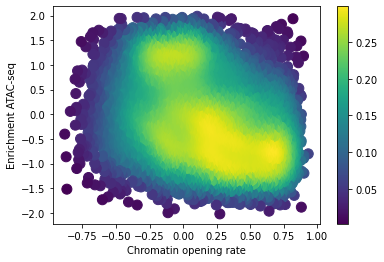

In [69]:
#Correlation between chromatin accessibility and H3K9ac
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 
cbar = fig.colorbar(scatter)
#Correlation between acetylation profile and H3K9ac
plt.xlabel("Chromatin opening rate") 
plt.ylabel("Enrichment ATAC-seq") 
plt.savefig("corr_1ac_all.svgz")

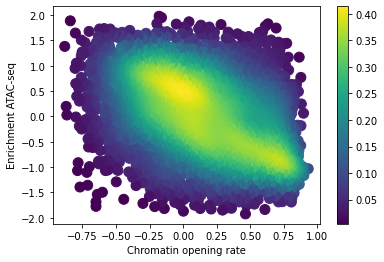

In [70]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_2ac_all.svgz")

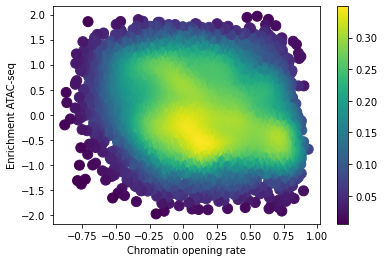

In [71]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_3ac_all.svgz")

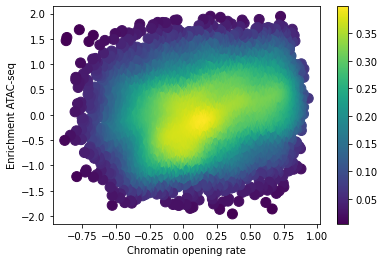

In [72]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_4ac_all.svgz")

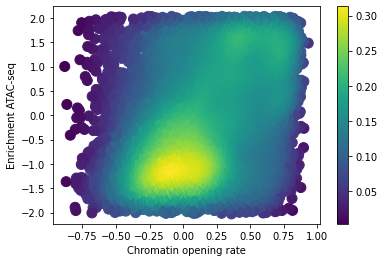

In [73]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T5"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_5ac_all.svgz")

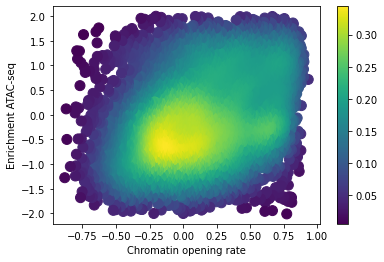

In [74]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_6ac_all.svgz")

### Figure 5A- 5F

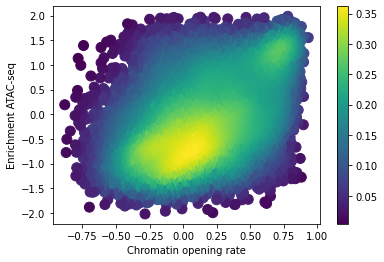

In [57]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
#Correlation between methylation profile and H3K4me3
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_1me_all.svgz")

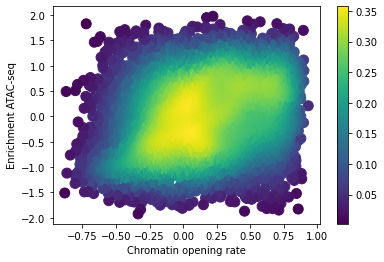

In [58]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)

plt.savefig("corr_2me_all.svgz")

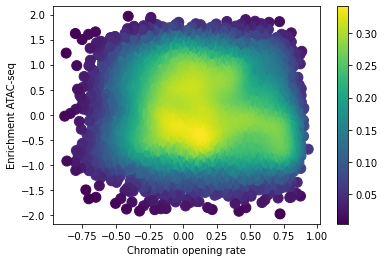

In [59]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)

plt.savefig("corr_3me_all.svgz")

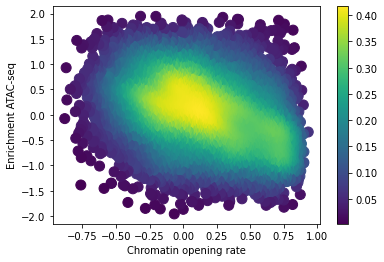

In [60]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)

plt.savefig("corr_4me_all.svgz")

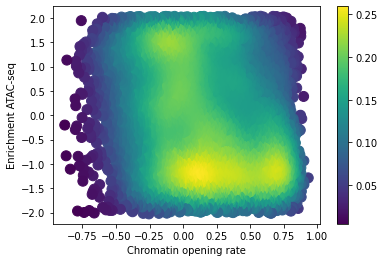

In [61]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T5"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)

plt.savefig("corr_5me_all.svgz")

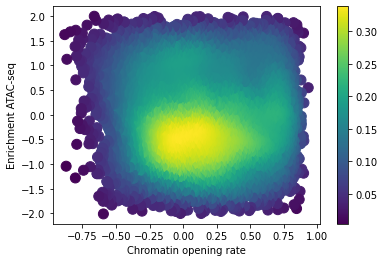

In [62]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

cbar = fig.colorbar(scatter)
plt.savefig("corr_6me_all.svgz")